In [1]:
import numpy as np
import matplotlib.pyplot as pp
import pandas as pd
import heapq
import pycbc.waveform
from pycbc.types import FrequencySeries
%matplotlib inline
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
import matplotlib as mpl
import time
import multiprocessing
from joblib import Parallel, delayed
from scipy.signal import find_peaks, find_peaks_cwt
import scipy.special as sc
from scipy import interpolate
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3e' % x)
plotdirName = "/Users/saifali/Desktop/gwlensing/plots/"

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from matplotlib.ticker import MaxNLocator
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 25
mpl.rcParams['legend.handlelength'] = 3.0
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 1.0
mpl.rcParams['xtick.major.size'] = 5.0
mpl.rcParams['xtick.minor.size'] = 3.0
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 1.0
mpl.rcParams['ytick.major.size'] = 5.0
mpl.rcParams['ytick.minor.size'] = 3.0
mpl.rcParams['ytick.right'] = True

plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{sfmath}'


In [3]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec
year = 31557600 #[year] = sec
def unlensed_waveform(f, **args):
    
    theta_s = args['theta_s']
    phi_s = args['phi_s']
    theta_l = args['theta_l']
    phi_l = args['phi_l']
    mcz = args['mcz']
    dist = args['dist']
    eta = args['eta']
    
    def limit(mcz, eta):
        low_limit = 20
        f_cut = 1 / (np.power(6, 3/2) * np.pi * ((mcz) / (np.power(eta, 3/5))))
        return low_limit, f_cut
    
    """
    This file is just functionized form of L_unlensed(which was "object-oriented"). This was mainly created
    for the optimization of overlap function.
    """
    def mass_conv(mcz, eta):
        """Converts chirp mass to total mass. M = mcz/eta^(3/5)
        """

        M_val = mcz/np.power(eta, 3/5)
        return M_val

    def l_dot_n(theta_s, theta_l, phi_s, phi_l):
        """TODO
        """

        cos_term = np.cos(theta_s) * np.cos(theta_l)
        sin_term = np.sin(theta_s) * np.sin(theta_l) * np.cos(phi_s - phi_l)

        inner_prod = cos_term + sin_term
        return inner_prod

    def amp(mcz, dist):
        """TODO
        """

        amplitude = np.sqrt(5 / 96) * np.power(np.pi, -2 / 3) * np.power(mcz, 5 / 6) / (dist)
        return amplitude

    def psi(f, tc, phi_c, mcz, eta):
        """eqn 3.13 in Cutler-Flanaghan 1994
        """

        front_terms = 2 * np.pi * f * tc - phi_c - np.pi / 4
        main_coeffs = 0.75 * np.power(8 * np.pi * mcz * f, -5 / 3)
        main_terms = (1 + 20 / 9 * (743 / 336 + 11 / 4 * eta) * np.power(np.pi * mass_conv(mcz, eta) * f, 2 / 3)
                        - (16 * np.pi) * np.power(np.pi * mass_conv(mcz, eta) * f, 1))

        psi_val = front_terms + main_coeffs * (main_terms)
        return psi_val

    def psi_s(theta_s, theta_l, phi_s, phi_l):

        numerator = np.cos(theta_l)-np.cos(theta_s)*(l_dot_n(theta_s, theta_l, phi_s, phi_l))
        denominator = np.sin(theta_s)*np.sin(theta_l)*np.sin(phi_l-phi_s)

        psi_s_val = np.arctan2(numerator, denominator)
        return psi_s_val


    def fIp(theta_s, phi_s):
        """TODO
        """

        term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)* np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
        term_2 = (np.cos(theta_s) * np.sin(2*phi_s)* np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

        fIp_val = term_1 - term_2
        return fIp_val

    def fIc(theta_s, phi_s):
        """TODO
        """

        term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)
                    * np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
        term_2 = (np.cos(theta_s) * np.sin(2*phi_s)
                    * np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

        fIc_val = term_1 + term_2
        return fIc_val

    def lambdaI():
        """TODO
        """

        term_1 = np.power(2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s), 2)
        term_2 = np.power((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s), 2)

        lambdaI_val = np.sqrt(term_1 + term_2)
        return lambdaI_val

    def phi_pI():
        """TODO
        """

        numerator = (2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s))
        denominator = ((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s))

        phi_pI_val = np.arctan2(numerator, denominator)
        return phi_pI_val

    term_1 = lambdaI()
    term_2 = (np.exp(-1j * phi_pI()))
    term_3 = amp(mcz, dist) * np.power(f, -7 / 6)
    
    signal_I = term_1 * term_2 * term_3
    
    return signal_I

In [4]:
def Sn(f):
        """From table 1 of arXiv:0903.0338. Changed from iLIGO to aLIGO.
        """
        fs = 20
        if f < fs:
            Sn_val = np.inf
        else:
            S0 = 1E-49
            f0 = 215
            Sn_temp = np.power(f/f0, -4.14) - 5 * np.power(f/f0, -2) + 111 * ((1 - np.power(f/f0, 2) + 0.5 * np.power(f/f0, 4)) / (1 + 0.5 * np.power(f/f0, 2)))
            Sn_val = Sn_temp * S0

        return Sn_val

In [5]:
from mpmath import *
def amp_fact_sis_wo(f, y, ML):
    
    w = 8 * pi * ML * f
    pre_factor = exp(1j * (w / 2) * (y**2 + 2 * (y + 0.5)))
    func = lambda n: (gamma(1 + n / 2) / fac(n)) * (2 * w * exp(1j * 3 * (pi / 2))) ** (n / 2) * hyp1f1(1 + n / 2, 1, -1j * (w / 2) * y ** 2)
    series_sum = nsum(func, [0, inf])

    F_val_sis = np.complex128(pre_factor * series_sum, dtype = np.complex128)

    return F_val_sis

In [6]:
def magnification(y, ML, lens = 'sis'):
    
        if lens == 'pm':
            mu_plus = np.abs(0.5 + (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
            mu_minus = np.abs(0.5 - (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
        
        elif lens == 'sis':
            mu_plus = np.abs(1 + 1 / y)
            mu_minus = np.abs(-1 + 1 / y)
        
        return mu_minus / mu_plus, mu_plus, mu_minus

def time_del(y, ML, lens = 'sis'):

    if lens == 'pm':
        first_term = (y * (y ** 2 + 4) ** 0.5) / 2
        second_term = np.log(((y ** 2 + 4) ** 0.5 + y) / ((y ** 2 + 4) ** 0.5 - y))
        tds = 4 * ML * (first_term + second_term)

    elif lens == 'sis':
        tds = 8 * ML * y

    return tds

In [7]:
def invert_lensparam_to_sis(I, td):
    y = (1 - I) / (1 + I)
    ML = td / (8 * y)  
    return y, ML

######################################################################

In [8]:
I_t = [0.4, 0.6]
td_t = [0.0181, 0.0179]

In [9]:
freq = np.linspace(20, 95.68, 200)
F_sis_t = np.zeros((2, 200), dtype = np.complex128)

for i in range(len(td_t)):
    y, ML = invert_lensparam_to_sis(I_t[i], td_t[i])
    for j in range(len(freq)):
        F_sis_t[i][j] = amp_fact_sis_wo(freq[j], y, ML)

In [10]:
integrand_t = np.zeros((2, 200), dtype = np.complex128)
integrand_t_d1 = np.zeros((2, 200), dtype = np.complex128)
integrand_t_d2 = np.zeros((2, 200), dtype = np.complex128)

for i in range(len(I_t)):
    for j in range(len(freq)):

        hf_temp = unlensed_waveform(freq[j], theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0,
                               mcz = 20 * solar_mass, dist = 1 * giga_parsec, eta= 0.25) 

        y, ML = invert_lensparam_to_sis(I_t[i], td_t[i])
        F_sis = amp_fact_sis_wo(freq[j], y, ML)
        integrand_t[i][j] = (np.abs(F_sis) * np.abs(hf_temp) ** 2) / Sn(freq[j])
        integrand_t_d1[i][j] = (np.abs(F_sis) * np.abs(hf_temp))  ** 2 / Sn(freq[j])
        integrand_t_d2[i][j] = (np.abs(hf_temp))  ** 2 / Sn(freq[j])

In [11]:
max_freq = freq[np.where(np.abs(integrand_t_d2[0]) == np.max(np.abs(integrand_t_d2[0])))]

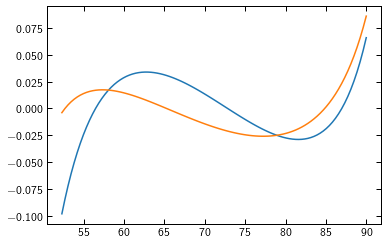

In [12]:
from scipy import stats
m_t = np.zeros_like(td_t)
y_int_t = np.zeros_like(td_t)

for i in range(len(I_t)):
    x = freq[85:185]
    y = np.angle(F_sis_t[i])[85:185]
    res = stats.linregress(x, y)
    y_int_t[i] = res.intercept
    m_t[i] = res.slope
    plt.plot(x, - y + (m_t[i]*x + y_int_t[i]))

In [13]:
delta_p_t = np.zeros((2, 200))

for i in range(len(I_t)):
    for j in range(len(freq)):
        delta_p_t[i][j] = freq[j] * m_t[i] + (y_int_t[i]) - np.angle(F_sis_t[i])[j]

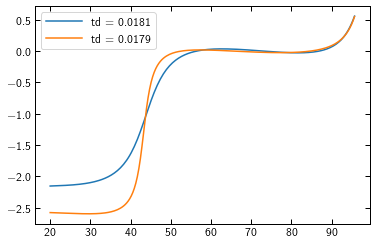

In [14]:
for i in range(len(td_t)):
    plt.plot(freq, delta_p_t[i], label = f'td = {td_t[i]}')
plt.legend()

######################################################################

In [15]:
I = 0.6
td = [0.0131, 0.0179, 0.0212]

In [16]:
freq = np.linspace(20, 95.68, 200)
F_sis = np.zeros((3, 200), dtype = np.complex128)

for i in range(len(td)):
    y, ML = invert_lensparam_to_sis(I, td[i])
    for j in range(len(freq)):
        F_sis[i][j] = amp_fact_sis_wo(freq[j], y, ML)

In [17]:
integrand = np.zeros((3, 200), dtype = np.complex128)
integrand_d1 = np.zeros((3, 200), dtype = np.complex128)
integrand_d2 = np.zeros((3, 200), dtype = np.complex128)

for i in range(len(td)):
    for j in range(len(freq)):

        hf_temp = unlensed_waveform(freq[j], theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0,
                               mcz = 20 * solar_mass, dist = 1 * giga_parsec, eta= 0.25) 

        y, ML = invert_lensparam_to_sis(I, td[i])
        F_sis_temp = amp_fact_sis_wo(freq[j], y, ML)
        integrand[i][j] = (np.abs(F_sis_temp) * np.abs(hf_temp) ** 2) / Sn(freq[j])
        integrand_d1[i][j] = (np.abs(F_sis_temp) * np.abs(hf_temp)) ** 2 / Sn(freq[j])
        integrand_d2[i][j] = (np.abs(hf_temp)) ** 2 / Sn(freq[j])

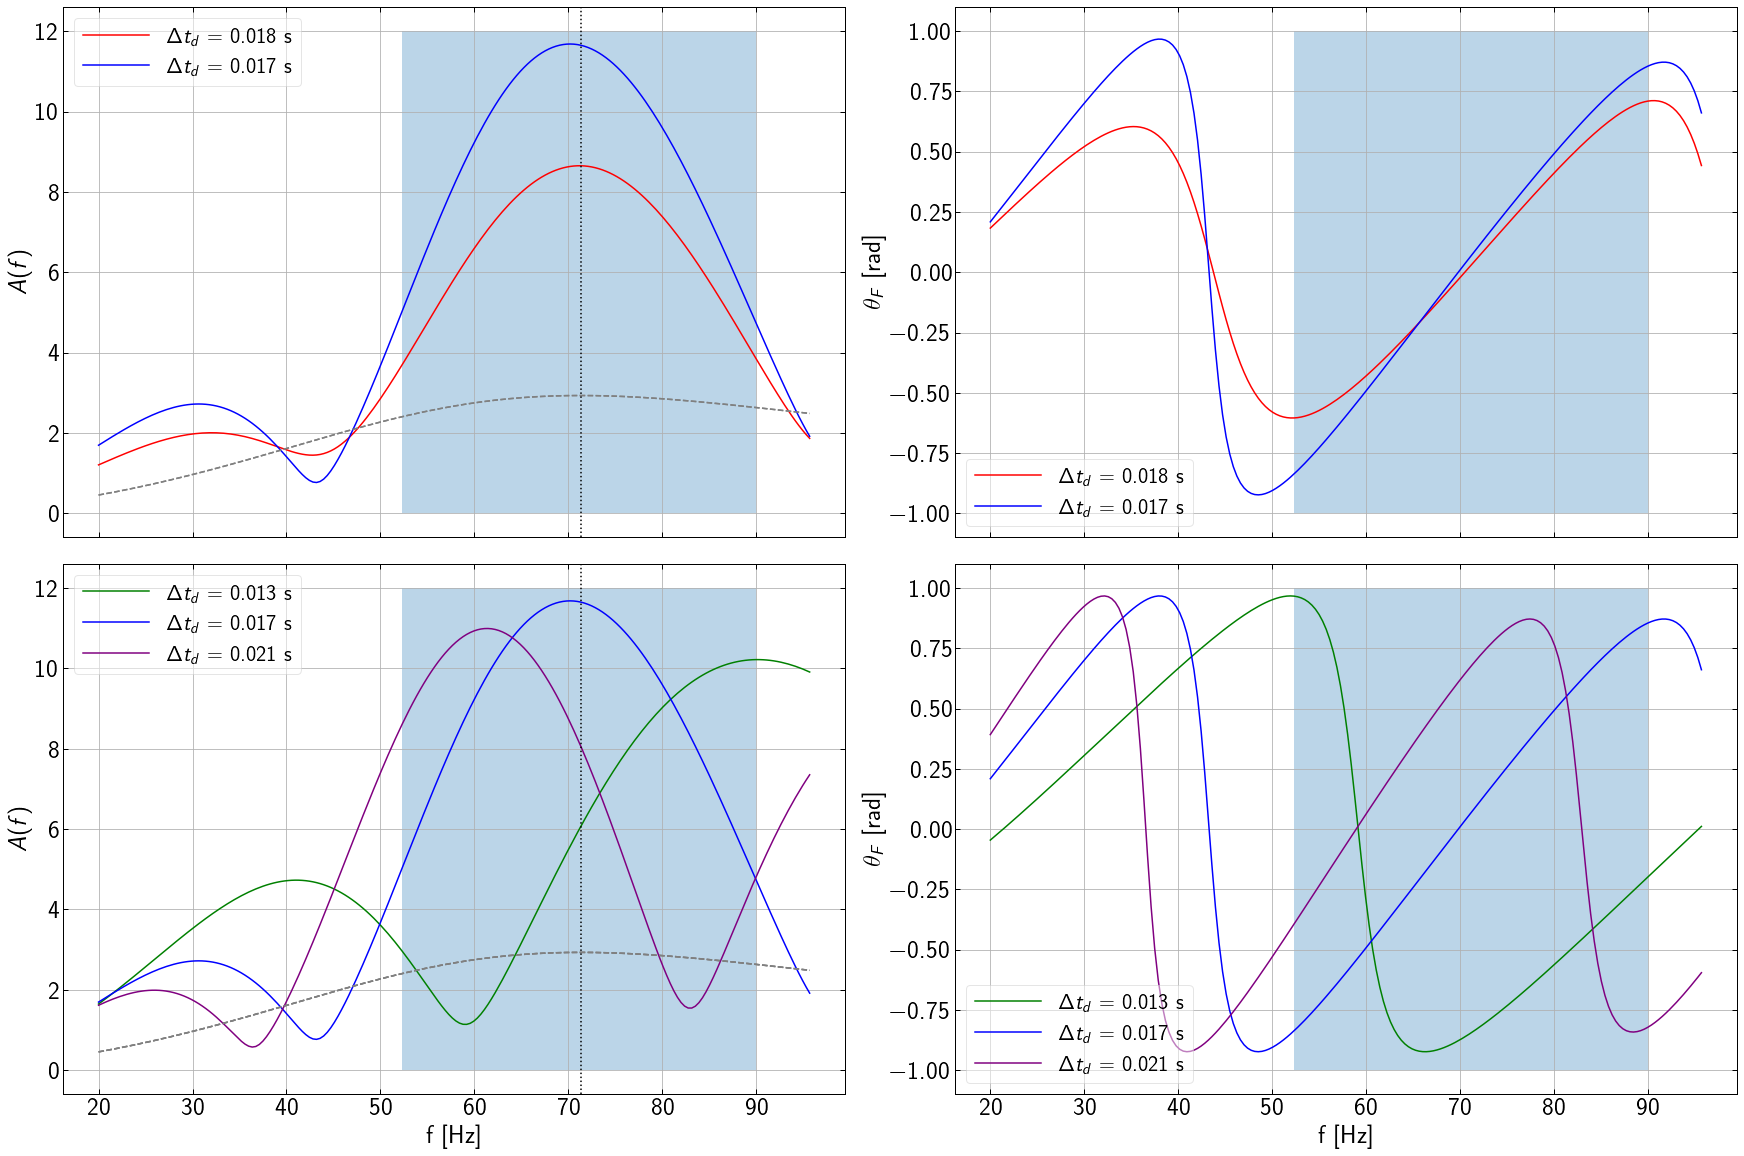

In [18]:
import matplotlib
matplotlib.rc('font', size=25)

c_t = ['red', 'blue']
td_t_label = ['0.018', '0.017']

fig, axs = plt.subplots(2, 2, figsize = (30, 20), sharex = True, gridspec_kw={'hspace': .05, 'wspace': .14})

for i in range(len(td_t)):
    axs[0, 1].plot(freq, np.angle(F_sis_t[i]), label = f'$\Delta t_d$ = {td_t_label[i]} s', c = c_t[i])
axs[0, 1].tick_params(axis='both', which='major', labelsize=25)
axs[0, 1].fill_between(freq[85:185], -1, 1, alpha = 0.3, linewidth = 0, facecolor = 'C10')
# axs[0, 1].set_xlabel('f [Hz]', fontsize = 25)
axs[0, 1].set_ylabel(r'$\theta_F$ [rad]', fontsize = 25)
axs[0, 1].grid()
axs[0, 1].legend(fontsize=22, framealpha = 0.5)

for i in range(len(td_t)):
    axs[0, 0].plot(freq, np.abs(integrand_t[i]), label = f'$\Delta t_d$ = {td_t_label[i]} s', c = c_t[i])
    #axs[0, 0].plot(freq, np.abs(integrand_t_d1[i]), c = c_t[i], ls ='-.')
    axs[0, 0].plot(freq, np.abs(integrand_t_d2[i]), c = 'gray', ls = '--')
axs[0, 0].tick_params(axis='both', which='major', labelsize=25)
axs[0, 0].axvline(max_freq, ls = 'dotted', c = 'black')
axs[0, 0].fill_between(freq[85:185], 0, 12, alpha = 0.3, linewidth = 0, facecolor = 'C10')
axs[0, 0].grid()
# axs[0, 0].set_xlabel('f [Hz]', fontsize = 25)
axs[0, 0].set_ylabel(r'$A(f)$', fontsize = 25)
axs[0, 0].legend(fontsize=22, framealpha = 0.5)

c = ['green', 'blue', 'purple']
td_label = ['0.013', '0.017', '0.021']

for i in range(len(td)):
    axs[1, 1].plot(freq, np.angle(F_sis[i]), label = f'$\Delta t_d$ = {td_label[i]} s', c = c[i])
axs[1, 1].tick_params(axis='both', which='major', labelsize=25)
axs[1, 1].fill_between(freq[85:185], -1, 1, alpha = 0.3, linewidth = 0, facecolor = 'C10')
axs[1, 1].set_xlabel('f [Hz]', fontsize = 25)
axs[1, 1].set_xlabel('f [Hz]', fontsize = 25)
axs[1, 1].set_ylabel(r'$\theta_F$ [rad]', fontsize = 25)
axs[1, 1].grid()
axs[1, 1].legend(fontsize=22, framealpha = 0.5)

for i in range(len(td)):
    axs[1, 0].plot(freq, np.abs(integrand[i]), label = f'$\Delta t_d$ = {td_label[i]} s', c = c[i])
    #axs[1, 0].plot(freq, np.abs(integrand_d1[i]), c = c[i], ls ='-.')
    axs[1, 0].plot(freq, np.abs(integrand_d2[i]), c = 'gray', ls = '--')
axs[1, 0].tick_params(axis='both', which='major', labelsize=25)
axs[1, 0].axvline(max_freq, ls = 'dotted', c = 'black')
axs[1, 0].fill_between(freq[85:185], 0, 12, alpha = 0.3, linewidth = 0, facecolor = 'C10')
axs[1, 0].grid()
axs[1, 0].set_xlabel('f [Hz]', fontsize = 25)
axs[1, 0].set_ylabel(r'$A(f)$', fontsize = 25)
axs[1, 0].legend(fontsize=22, framealpha = 0.5)

# plt.savefig(plotdirName + 'big_dip_amp_delta_F.pdf', dpi = 500, bbox_inches = 'tight')

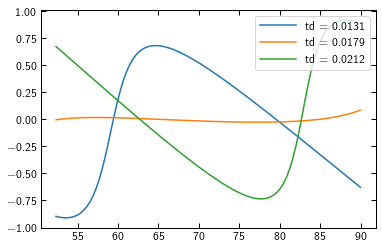

In [19]:
from scipy import stats

m = np.zeros_like(td)
y_int = np.zeros_like(td)

for i in range(len(td)):
    x = freq[85:185]
    y = np.angle(F_sis[i])[85:185]
    res = stats.linregress(x, y)
    y_int[i] = res.intercept
    m[i] = res.slope
    plt.plot(x, - y + (m[i]*x + y_int[i]), label = f'td = {td[i]}')
plt.legend()

In [20]:
delta_p = np.zeros((3, 200))

for i in range(len(td)):
    for j in range(len(freq)):
        delta_p[i][j] = freq[j] * m[i] + (y_int[i]) - np.angle(F_sis[i])[j]

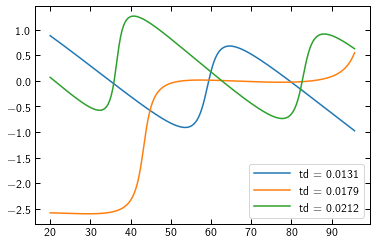

In [21]:
for i in range(len(td)):
    plt.plot(freq, delta_p[i], label = f'td = {td[i]}')
plt.legend()

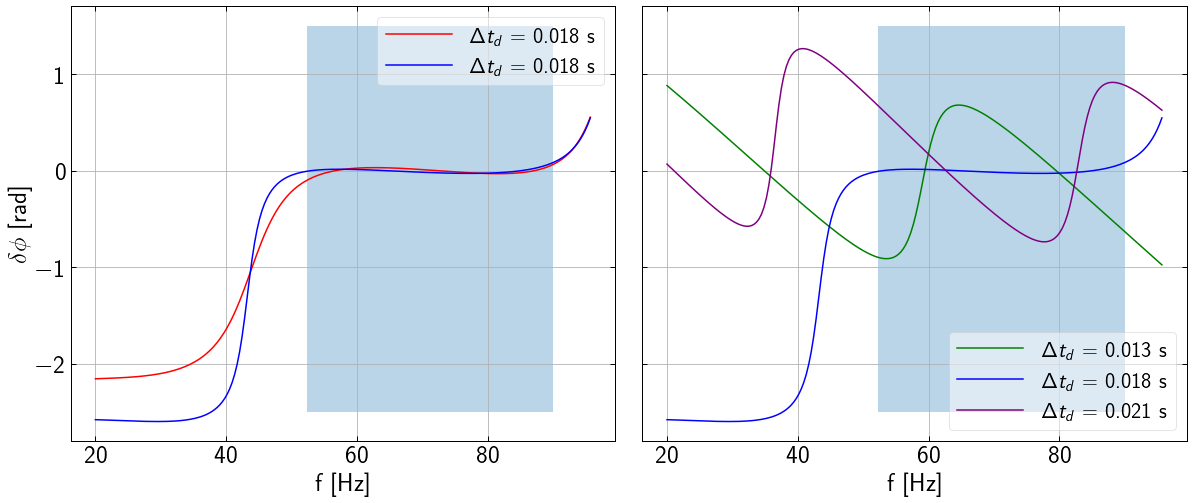

In [22]:
import matplotlib
matplotlib.rc('font', size=25)

fig, axs = plt.subplots(1, 2, figsize = (20, 8), sharey = True, gridspec_kw={'wspace': .05})

for i in range(len(td_t)):
    axs[0].plot(freq, delta_p_t[i], label = f'$\Delta t_d$ = {td_t[i]:.3f} s', c = c_t[i])
axs[0].tick_params(axis='both', which='major', labelsize=25)
axs[0].set_xlabel('f [Hz]', fontsize = 25)
axs[0].set_ylabel(r'$\delta \phi$ [rad]', fontsize = 25)
axs[0].grid()
axs[0].fill_between(freq[85:185], -2.5, 1.5, alpha = 0.3, linewidth = 0, facecolor = 'C10')
axs[0].legend(fontsize=22, framealpha = 0.5)

for i in range(len(td)):
    axs[1].plot(freq, delta_p[i], label = f'$\Delta t_d$ = {td[i]:.3f} s', c = c[i])
axs[1].tick_params(axis='both', which='major', labelsize=25)
axs[1].grid()
axs[1].set_xlabel('f [Hz]', fontsize = 25)
axs[1].legend(fontsize=22, framealpha = 0.5)
axs[1].fill_between(freq[85:185], -2.5, 1.5, alpha = 0.3, linewidth = 0, facecolor = 'C10')
# plt.savefig(plotdirName + 'big_dip_delta_phi.pdf', dpi = 500, bbox_inches = 'tight')

## General analysis

In [25]:
from scipy.signal import find_peaks

file_list = [
            "pycbc_1d_match_sis_ml_fluxratio_0pt2.csv",
            ]
y_list = [0.2]

data_1d_y_0pt2 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/'+str(file_list[0]), header = None, converters = {1: eval})
data_1d_y_0pt2['td'] = np.array([data_1d_y_0pt2[1][i][1] for i in range(len(data_1d_y_0pt2))])
data_1d_y_0pt2['match'] = np.array([data_1d_y_0pt2[1][i][2] for i in range(len(data_1d_y_0pt2))])
data_1d_y_0pt2 = data_1d_y_0pt2.sort_values(by = 0)
# data_1d_y_0pt2 = data_1d_y_0pt2.iloc[:320]
peaks, _ = find_peaks(1 - data_1d_y_0pt2['match'])
troughs, _ = find_peaks(data_1d_y_0pt2['match'])
peaks_arr = np.array(data_1d_y_0pt2['td'])[peaks][-3:]
troughs_arr = np.array(data_1d_y_0pt2['td'])[troughs][-2:]

#peaks_arr = np.delete(peaks_arr, 2)
#troughs_arr = np.delete(troughs_arr, 1)
peaks_arr, troughs_arr

(array([0.13658514, 0.14659149, 0.1577986 ]), array([0.14178844, 0.15179479]))

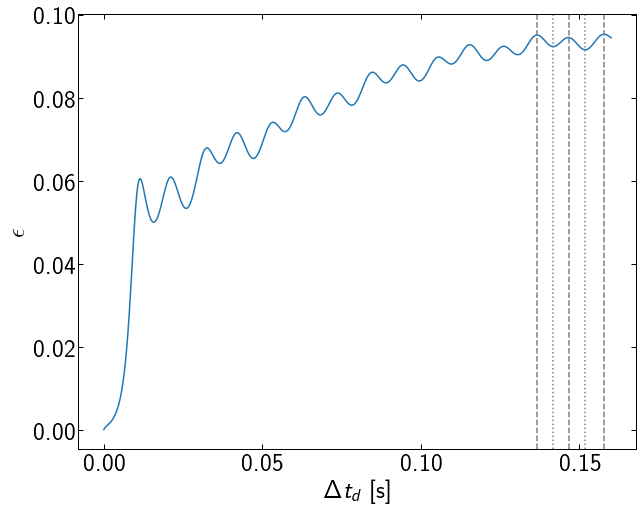

In [26]:
c1 = ['red', 'green']
c2 = ['blue', 'orange']

plt.figure(figsize = (10, 8))
plt.plot(data_1d_y_0pt2['td'], 1 - data_1d_y_0pt2['match'], label = f'I = {y_list[0]}')
for i in range(len(peaks_arr)):
    plt.axvline(peaks_arr[i], ls = '--', c = 'gray')
for j in range(len(troughs_arr)):
    plt.axvline(troughs_arr[j], ls = 'dotted', c = 'gray')
# plt.legend(fontsize=22, framealpha = 0.5)
plt.xlabel(r'$\Delta t_d$ [s]', fontsize = 25)
plt.ylabel(r'$\epsilon$', fontsize = 25)
plt.tick_params(axis='both', which='major', labelsize=25)
# plt.grid(alpha = 0.5)
# plt.savefig(plotdirName + 'mismatch_mcz_20_I_0.2.pdf', dpi = 500, bbox_inches = 'tight')

In [27]:
f_cut = (0.25)**(3/5) / (6 ** (3/2) * np.pi * 20 * solar_mass)
f_cut

95.68450797230712

In [28]:
I = 0.2
f_cut = (0.25)**(3/5) / (6 ** (3/2) * np.pi * 20 * solar_mass)
freq = np.linspace(20, f_cut, 200)
F_sis_tg = np.zeros((len(troughs_arr), len(freq)), dtype = np.complex128)

for i in range(len(troughs_arr)):
    y, ML = invert_lensparam_to_sis(I, troughs_arr[i])
    for j in range(len(freq)):
        F_sis_tg[i][j] = amp_fact_sis_wo(freq[j], y, ML)

In [29]:
F_sis_g = np.zeros((len(peaks_arr), len(freq)), dtype = np.complex128)

for i in range(len(peaks_arr)):
    y, ML = invert_lensparam_to_sis(I, peaks_arr[i])
    for j in range(len(freq)):
        F_sis_g[i][j] = amp_fact_sis_wo(freq[j], y, ML)

In [30]:
integrand_t_g = np.zeros((len(troughs_arr), len(freq)), dtype = np.complex128)
integrand_t_d1_g = np.zeros((len(troughs_arr), len(freq)), dtype = np.complex128)
integrand_t_d2_g = np.zeros((len(troughs_arr), len(freq)), dtype = np.complex128)

for i in range(len(troughs_arr)):
    for j in range(len(freq)):

        hf_temp = unlensed_waveform(freq[j], theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0,
                               mcz = 20 * solar_mass, dist = 1 * giga_parsec, eta= 0.25) 

        y, ML = invert_lensparam_to_sis(I, troughs_arr[i])
        F_sis_temp = amp_fact_sis_wo(freq[j], y, ML)
        integrand_t_g[i][j] = (np.abs(F_sis_temp) * np.abs(hf_temp) ** 2) / Sn(freq[j])
        integrand_t_d1_g[i][j] = (np.abs(F_sis_temp) * np.abs(hf_temp)) ** 2 / Sn(freq[j])
        integrand_t_d2_g[i][j] = (np.abs(hf_temp)) ** 2 / Sn(freq[j])

In [31]:
integrand_g = np.zeros((len(peaks_arr), len(freq)), dtype = np.complex128)
integrand_d1_g = np.zeros((len(peaks_arr), len(freq)), dtype = np.complex128)
integrand_d2_g = np.zeros((len(peaks_arr), len(freq)), dtype = np.complex128)

for i in range(len(peaks_arr)):
    for j in range(len(freq)):

        hf_temp = unlensed_waveform(freq[j], theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0,
                               mcz = 20 * solar_mass, dist = 1 * giga_parsec, eta= 0.25) 

        y, ML = invert_lensparam_to_sis(I, peaks_arr[i])
        F_sis_temp = amp_fact_sis_wo(freq[j], y, ML)
        integrand_g[i][j] = (np.abs(F_sis_temp) * np.abs(hf_temp) ** 2) / Sn(freq[j])
        integrand_d1_g[i][j] = (np.abs(F_sis_temp) * np.abs(hf_temp)) ** 2 / Sn(freq[j])
        integrand_d2_g[i][j] = (np.abs(hf_temp)) ** 2 / Sn(freq[j])

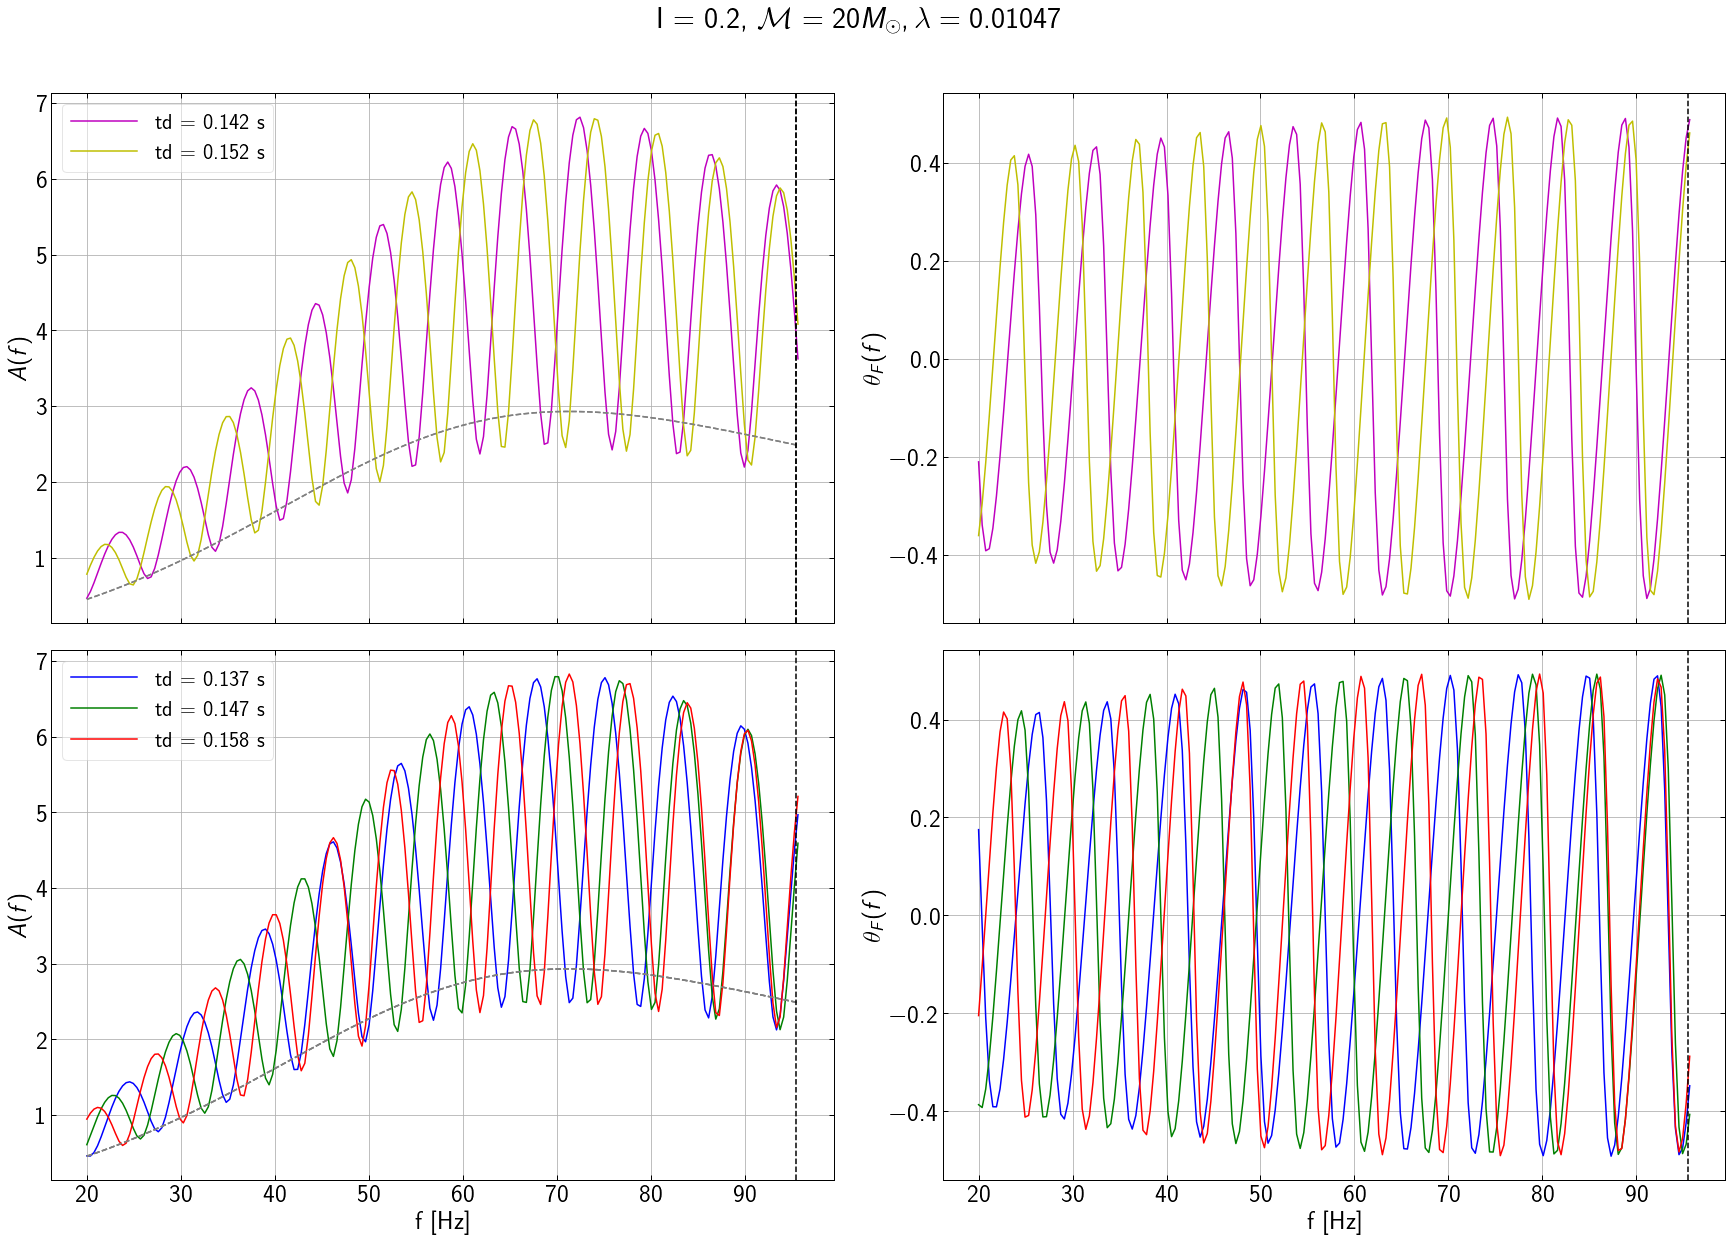

In [33]:
import matplotlib
matplotlib.rc('font', size=25)

c1 = ['b', 'g', 'r']
c2 = ['m', 'y']
fig, axs = plt.subplots(2, 2, figsize = (30, 20), sharex = True, gridspec_kw={'hspace': .05, 'wspace': .14})

for i in range(len(troughs_arr)):
    axs[0, 0].plot(freq, np.abs(integrand_t_g[i]), label = f'td = {troughs_arr[i]:.3f} s', c = c2[i])
    #axs[0, 0].plot(freq, np.abs(integrand_t_d1_g[i]), ls ='-.', c = c1[i])
    axs[0, 0].plot(freq, np.abs(integrand_t_d2_g[i]), c = 'gray', ls = '--')
    axs[0, 0].legend(fontsize=22, framealpha = 0.5)
axs[0, 0].tick_params(axis='both', which='major', labelsize=25)
axs[0, 0].axvline(1 / 0.01047, ls = '--', c = 'black')
axs[0, 0].axvline(1 / 0.01047, ls = '--', c = 'black')
#axs.fill_between(freq[85:185], 0, 12, alpha = 0.3, linewidth = 0, facecolor = 'C10')
axs[0, 0].grid()
# axs[0, 0].set_xlabel('f [Hz]', fontsize = 25)
axs[0, 0].set_ylabel(r'$A(f)$', fontsize = 25)
axs[0, 0].tick_params(axis='both', which='major', labelsize=25)

for i in range(len(troughs_arr)):
    axs[0, 1].plot(freq, np.angle(F_sis_tg[i]), label = f'td = {troughs_arr[i]:.3f} s', c = c2[i])
#     axs[0, 1].legend(fontsize=22, framealpha = 0.5, loc = 'upper left')
axs[0, 1].tick_params(axis='both', which='major', labelsize=25)
axs[0, 1].axvline(1 / 0.01047, ls = '--', c = 'black')
#axs.fill_between(freq[85:185], 0, 12, alpha = 0.3, linewidth = 0, facecolor = 'C10')
axs[0, 1].grid()
# axs[0, 0].set_xlabel('f [Hz]', fontsize = 25)
axs[0, 1].set_ylabel(r'$\theta_F(f)$', fontsize = 25)
axs[0, 1].tick_params(axis='both', which='major', labelsize=25)

for i in range(len(peaks_arr)):
    axs[1, 0].plot(freq, np.abs(integrand_g[i]), label = f'td = {peaks_arr[i]:.3f} s', c = c1[i])
    #axs[1, 0].plot(freq, np.abs(integrand_d1_g[i]), ls ='-.', c = c2[i])
    axs[1, 0].plot(freq, np.abs(integrand_d2_g[i]), c = 'gray', ls = '--')
    axs[1, 0].legend(fontsize=22, framealpha = 0.5)
axs[1, 0].tick_params(axis='both', which='major', labelsize=25)
axs[1, 0].axvline(1 / 0.01047, ls = '--', c = 'black')
#axs.fill_between(freq[85:185], 0, 12, alpha = 0.3, linewidth = 0, facecolor = 'C10')
axs[1, 0].grid()
axs[1, 0].set_xlabel('f [Hz]', fontsize = 25)
axs[1, 0].set_ylabel(r'$A(f)$', fontsize = 25)
axs[1, 0].tick_params(axis='both', which='major', labelsize=25)

for i in range(len(peaks_arr)):
    axs[1, 1].plot(freq, np.angle(F_sis_g[i]), label = f'td = {peaks_arr[i]:.3f} s', c = c1[i])
#     axs[1, 1].legend(fontsize=22, framealpha = 0.5, loc = 'upper left')
axs[1, 1].tick_params(axis='both', which='major', labelsize=25)
axs[1, 1].axvline(1 / 0.01047, ls = '--', c = 'black')
# axs[1, 1].fill_between(freq[190:200], -0.6, 0.6, alpha = 0.3, linewidth = 0, facecolor = 'C10')
axs[1, 1].grid()
axs[1, 1].set_xlabel('f [Hz]', fontsize = 25)
axs[1, 1].set_ylabel(r'$\theta_F(f)$', fontsize = 25)
axs[1, 1].tick_params(axis='both', which='major', labelsize=25)
fig.suptitle(r'I = 0.2, $\mathcal{M} = 20 M_\odot, \lambda = 0.01047$', y = 0.94);
# plt.savefig(plotdirName + 'integrand_and_phase_mcz=20_I=0.2.pdf', bbox_inches = 'tight')

####################################################################################
####################################################################################
####################################################################################
####################################################################################


In [12]:
from scipy.signal import find_peaks

file_list = [
            "pycbc_1d_match_sis_ml_fluxratio_0pt2.csv",
            ]
y_list = [0.2]

data_1d_y_0pt2 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/'+str(file_list[0]), header = None, converters = {1: eval})
data_1d_y_0pt2['td'] = np.array([data_1d_y_0pt2[1][i][1] for i in range(len(data_1d_y_0pt2))])
data_1d_y_0pt2['match'] = np.array([data_1d_y_0pt2[1][i][2] for i in range(len(data_1d_y_0pt2))])
data_1d_y_0pt2 = data_1d_y_0pt2.sort_values(by = 0)
peaks, _ = find_peaks(1 - data_1d_y_0pt2['match'])
troughs, _ = find_peaks(data_1d_y_0pt2['match'])
peaks_arr = np.array(data_1d_y_0pt2['td'])[peaks]
troughs_arr = np.array(data_1d_y_0pt2['td'])[troughs]

## for mcz = 10 m_sol
# peaks_arr = np.delete(peaks_arr, 2)
# troughs_arr = np.delete(troughs_arr, 2)
peaks_arr, troughs_arr

(array([0.01150574, 0.02131197, 0.03251908, 0.04212518, 0.05353242,
        0.06353877, 0.07374525, 0.08475224, 0.09435833, 0.10576557,
        0.11537167, 0.12617853, 0.13658514, 0.14659149, 0.1577986 ]),
 array([0.01590854, 0.02611501, 0.03672175, 0.04732848, 0.0571347 ,
        0.06834182, 0.07814804, 0.0889549 , 0.09956164, 0.10956799,
        0.1207751 , 0.13058133, 0.14178844, 0.15179479]))

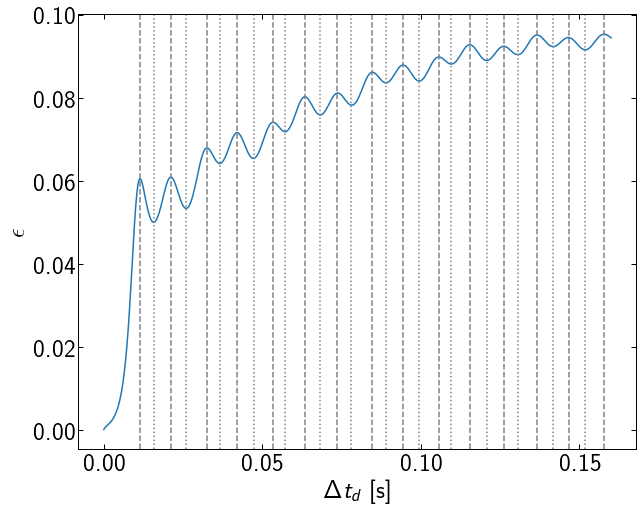

In [13]:
c1 = ['red', 'green']
c2 = ['blue', 'orange']

plt.figure(figsize = (10, 8))
plt.plot(data_1d_y_0pt2['td'], 1 - data_1d_y_0pt2['match'], label = f'I = {y_list[0]}')
for i in range(len(peaks_arr)):
    plt.axvline(peaks_arr[i], ls = '--', c = 'gray')
for j in range(len(troughs_arr)):
    plt.axvline(troughs_arr[j], ls = 'dotted', c = 'gray')
# plt.legend(fontsize=22, framealpha = 0.5)
plt.xlabel(r'$\Delta t_d$ [s]', fontsize = 25)
plt.ylabel(r'$\epsilon$', fontsize = 25)
plt.tick_params(axis='both', which='major', labelsize=25)

In [62]:
def get_td(n, osc_f = 191.2, inflection_pt = 'trough'):
    if inflection_pt == 'trough':
        td = (n + 1/2) / osc_f
    else:
        td = n / osc_f
    return td

In [64]:
td_peaks = np.zeros_like(peaks_arr)
td_troughs = np.zeros_like(troughs_arr)
for i in range(len(peaks_arr)):
    td_peaks[i] = get_td(i+2, inflection_pt = 'peaks')
for j in range(len(troughs_arr)):
    td_troughs[j] = get_td(j+2, inflection_pt = 'trough')
# df = pd.DataFrame({'Actual': peaks_arr, 'Predicted': td_peaks})
# df.to_latex()
np.c_[peaks_arr, td_peaks], np.c_[troughs_arr, td_troughs]

(array([[0.01082676, 0.01046025],
        [0.01563045, 0.01569038],
        [0.02123477, 0.0209205 ],
        [0.02683908, 0.02615063],
        [0.03212315, 0.03138075],
        [0.03708697, 0.03661088],
        [0.04221091, 0.041841  ],
        [0.04749498, 0.04707113],
        [0.05293917, 0.05230126],
        [0.05822324, 0.05753138],
        [0.06318706, 0.06276151],
        [0.06815088, 0.06799163],
        [0.07343495, 0.07322176],
        [0.07887914, 0.07845188]]), array([[0.01338873, 0.01307531],
        [0.01819243, 0.01830544],
        [0.02331637, 0.02353556],
        [0.02844031, 0.02876569],
        [0.03356426, 0.03399582],
        [0.03900845, 0.03922594],
        [0.04429252, 0.04445607],
        [0.04941646, 0.04968619],
        [0.05438028, 0.05491632],
        [0.05966435, 0.06014644],
        [0.06526866, 0.06537657],
        [0.07055273, 0.07060669],
        [0.07567667, 0.07583682]]))

In [14]:
wavelength = np.diff(troughs_arr)
wavelength, np.average(wavelength[-6:])

(array([0.01020648, 0.01060673, 0.01060673, 0.00980622, 0.01120711,
        0.00980622, 0.01080686, 0.01060673, 0.01000635, 0.01120711,
        0.00980622, 0.01120711, 0.01000635]), 0.010473314768460576)

In [278]:
def phase_hyp_A(i):
    wl = 100
    td_c = (i) / wl
    td_t = (i + 1 / 2)  / wl
    
    return td_c, td_t

def phase_hyp_B(i):
    wl = 100
    td_c = (i) / (2 * wl)
    td_t = (i + 1 / 2)  / (2 * wl)
    
    return td_c, td_t

def amp_hyp(i):
    wl = 100
    td_c = (i + 1 / 4) / wl
    td_t = (i + 3 / 4)  / wl
    
    return td_c, td_t

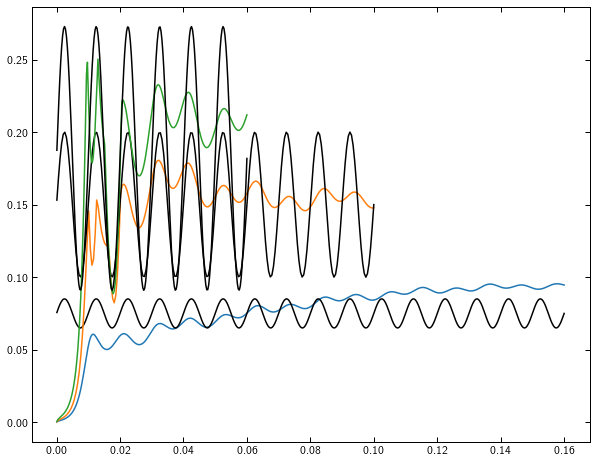

In [279]:
I_list = ['0.2', '0.4', '0.6']
phi_0 = [7.5, 3, 2]
norm = [100, 20, 11]

file_list = [
            "pycbc_1d_match_sis_ml_fluxratio_0pt2.csv",
            "pycbc_1d_match_sis_ml_fluxratio_0pt4.csv",
            "pycbc_1d_match_sis_ml_fluxratio_0pt6.csv"
            ]

plt.figure(figsize = (10, 8))
for i in range(len(file_list)):
    data_1d_y_0pt2 = pd.read_csv('/Users/saifali/Desktop/gwlensing/data/'+str(file_list[i]), header = None, converters = {1: eval})
    data_1d_y_0pt2['td'] = np.array([data_1d_y_0pt2[1][i][1] for i in range(len(data_1d_y_0pt2))])
    data_1d_y_0pt2['match'] = np.array([data_1d_y_0pt2[1][i][2] for i in range(len(data_1d_y_0pt2))])
    data_1d_y_0pt2 = data_1d_y_0pt2.sort_values(by = 0)
    
    plt.plot(data_1d_y_0pt2['td'], 1 - data_1d_y_0pt2['match'], label = f'I = {y_list[0]}')
#     plt.plot(data_1d_y_0pt2['td'],  (np.cos(2 * np.pi * (1 / 0.01) * data_1d_y_0pt2['td']) + phi_0[i]) / norm[i], c = 'red')
    plt.plot(data_1d_y_0pt2['td'],  (np.sin(2 * np.pi * (1 / 0.01) * data_1d_y_0pt2['td']) + phi_0[i]) / norm[i], c = 'black')

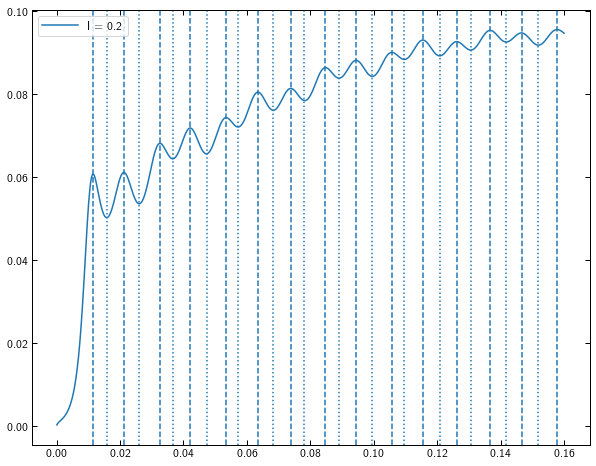

In [289]:
plt.figure(figsize = (10, 8))
plt.plot(data_1d_y_0pt2['td'], 1 - data_1d_y_0pt2['match'], label = f'I = {y_list[0]}')

# for i in range(1, 16):
#     td_c, td_t = amp_hyp(i)
#     plt.axvline(td_c, ls = '--', c = 'black')
#     plt.axvline(td_t, ls = 'dotted', c = 'black')
    
    
# for i in range(1, 6):
    
#     td_c_p, td_t_p = phase_hyp_A(i)
 
#     plt.axvline(td_c_p, ls = '--', c = 'red')
#     plt.axvline(td_t_p, ls = 'dotted', c = 'red')


# for I = 0.2
# plt.plot(data_1d_y_0pt2['td'],  (np.sin(2 * np.pi * (1 / 0.01) * data_1d_y_0pt2['td']) + 7.5) / 100, c = 'black')

# for I = 0.4
# plt.plot(data_1d_y_0pt2['td'],  (np.sin(2 * np.pi * (71) * data_1d_y_0pt2['td']) + 3) / 20, c = 'black')

# for I = 0.6
# plt.plot(data_1d_y_0pt2['td'],  (np.sin(2 * np.pi * (1 / 0.010) * data_1d_y_0pt2['td']) + 2) / 11, c = 'black')
    
for i in range(len(peaks_arr)):
    plt.axvline(peaks_arr[i], ls = '--')
for j in range(len(troughs_arr)):
    plt.axvline(troughs_arr[j], ls = 'dotted')

plt.legend()

In [319]:
invert_lensparam_to_sis(0.6, 0.06)

(0.25, 0.03)